In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import gymnasium as gym
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO,SAC
from Models import Models_env
#Global params
T = 26
nsteps = 100


In [234]:
SP = {
    'Ca': [0.8 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

#Continuous box action space
action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale ={
    '0': 5 #Reward scale for each state
}
disturbance = {
    'Caf': np.array([1 for i in range(int(nsteps/4))]+[1.05 for i in range(int(nsteps/2))]+[1 for i in range(int(nsteps/4))]),
}
env_params = {
    'Nx': 2, # Number of states
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'Nu':1, # Number of control/actions
    'SP':SP, #Setpoint
    'o_space' : observation_space, #Observation space
    'a_space' : action_space, # Action space
    'dt': 1., # Time step
    'x0': np.array([0.8,330,0.8]), # Initial conditions (torch.tensor)
    'model': 'cstr_ode', #Select the model
    'r_scale': r_scale, #Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':True, #Add noise to the states
    'integration_method': 'casadi', #Select the integration method
    'noise_percentage':0.001, #Noise percentage
    'disturbances':disturbance, #Disturbance
}



env = Models_env(env_params)

In [446]:
disturbance['Caf'][25]

1.05

Create casadi function of model

In [4]:
from casadi import *
T = MX.sym('T')
Ca = MX.sym('Ca')
x = vertcat(Ca,T)
u = MX.sym('u')
dxdt = env.model(x,u)
dxdt = vertcat(*dxdt)
f = Function('f',[x,u],[dxdt],['x','u'],['dxdt'])

Create integration object

In [5]:
# Time horizon
T = 10

# Number of control intervals
N = 20

# Integrator options
intg_options = {'tf': T/N, 'simplify': True, 'number_of_finite_elements': 4}

# DAE problem structure
dae = {'x': x, 'p': u, 'ode': f(x, u)}

# Create integrator
intg = integrator('intg', 'rk', dae, intg_options)

CasADi - 2024-02-07 11:50:11 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [6]:
res = intg(x0=x, p=u)
# Get the next state
x_next = res['xf']
F = Function('F',[x,u],[x_next],['x','u'],['x_next'])

In [7]:
F([0.8,330],295)

DM([0.827413, 323.09])

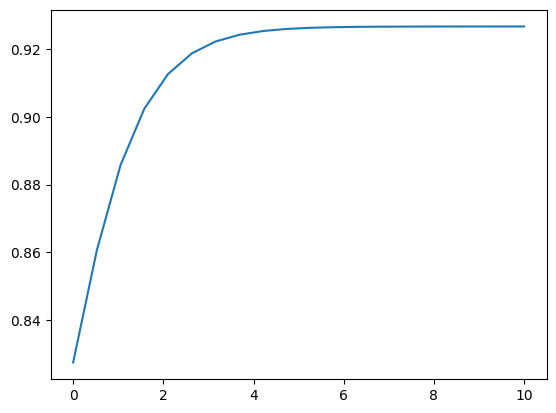

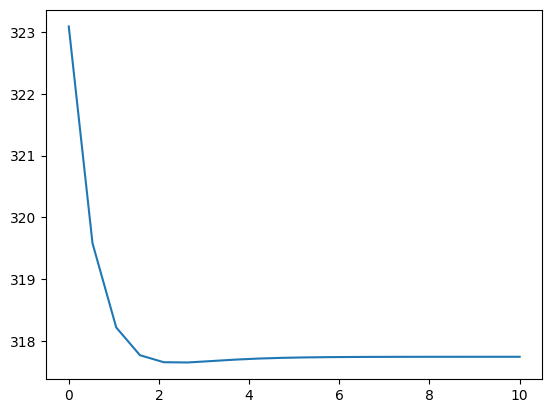

In [8]:
sim = F.mapaccum(N)
x0 = [0.8,330]
res = sim(x0, [295]*N)
plt.plot(np.linspace(0,T,N),res.full()[0,:])
plt.show()
plt.plot(np.linspace(0,T,N),res.full()[1,:])

Check jacobians

(20, 20)


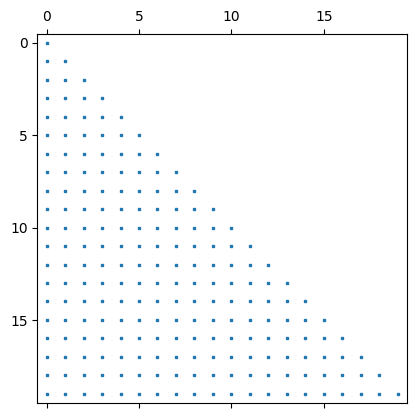

In [9]:
import scipy.sparse
U = MX.sym('U',1,N)
X1 = sim(x0,U)[0,:]
J = jacobian(X1,U)
print(J.shape)

# Create a sparsity pattern plot
rows, cols = J.sparsity().get_triplet()

# Create a sparse matrix
sparse_matrix = scipy.sparse.coo_matrix((np.ones(len(rows)), (rows, cols)))

# Create a sparsity pattern plot
plt.spy(sparse_matrix, markersize=2)
plt.show()

Create OCP

In [135]:
N = 4
opti  = Opti()
x = opti.variable(2, N+1)
u = opti.variable(1, N)
p = opti.parameter(2, 1)
setpoint = opti.parameter(2, N+1)

# Define the cost function as the sum of the squared deviations from the setpoint
cost = sum1(sum2((x - setpoint)**2))
opti.minimize(cost)

for k in range(N):
  opti.subject_to(x[:, k+1] == F(x[:, k], u[:, k]))
opti.subject_to(u >= 295)
opti.subject_to(u <= 302)
opti.subject_to(x[:, 0] == p )

In [136]:
opti.solver('ipopt')
setpoint_value = np.array([[0.9]*(N+1), [320]*(N+1)])   # Replace with your desired setpoint value
# Convert the array to a list
opti.set_value(setpoint, setpoint_value)
opti.set_value(p, [0.8,330])
initial_x_values = np.zeros((2, N+1))
initial_x_values[0, :] = 0.8
initial_x_values[1, :] = 330
opti.set_initial(x, initial_x_values)

# Set initial values for u
initial_u_values = 295 * np.ones((1, N))
opti.set_initial(u, initial_u_values)
# Solve the optimization problem
try:
    sol = opti.solve()
except:
    opti.debug.show_infeasibilities()



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       34
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:       26

Total number of variables............................:       14
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequality constraints...............:        8
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0005000e+02 6.91e+00 9.13e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

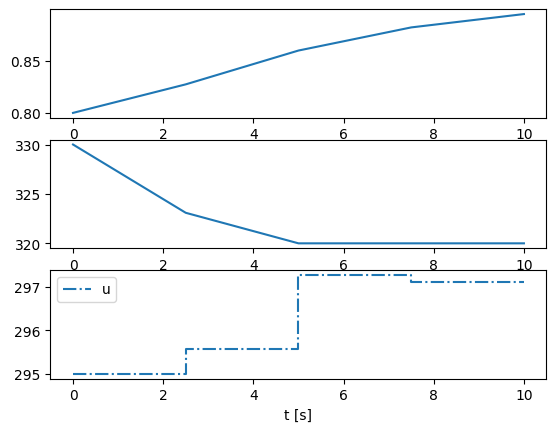

In [137]:
# Create a time grid for plotting
tgrid = np.linspace(0, T, N+1)

# Extract the optimal values
x_opt = sol.value(x)
u_opt = sol.value(u)
u_opt_stairs = np.append(u_opt, np.nan)
# Create a new figure
plt.figure()


# Plot x1 and x2
plt.subplot(3, 1, 1)
plt.plot(tgrid, x_opt[0, :], label='x1')
plt.subplot(3, 1, 2)
plt.plot(tgrid, x_opt[1, :], label='x2')

# Plot u with stairs and add a NaN at the end

plt.subplot(3, 1, 3)
plt.step(tgrid, u_opt_stairs, '-.', where='post', label='u')

# Add labels and legend
plt.xlabel('t [s]')
plt.legend()

# Show the plot
plt.show()

MPC Loop

In [138]:
# Set options
opts = {
  'ipopt': {
    'print_level': 0,
  },
  'print_time': 0
}

# Set solver and options
opti.solver('ipopt', opts)
M = opti.to_function('M', [p], [u], ['p'], ['u'])

In [147]:
# MPC loop
ts = 18
U_log = []
x_log = np.zeros((2,ts+1))
x = np.array(x0)
for i in range(ts+1):
    try:
        x_log[:,i] = x
    except:
        x_log[:,i] = x.reshape(-1)
    
    u = M(x).full()
    # simulate system
    
    U_log.append(u[:,1])
    x = F(x,u[:,1]).full() + np.random.randn(2,1)*0.01
    


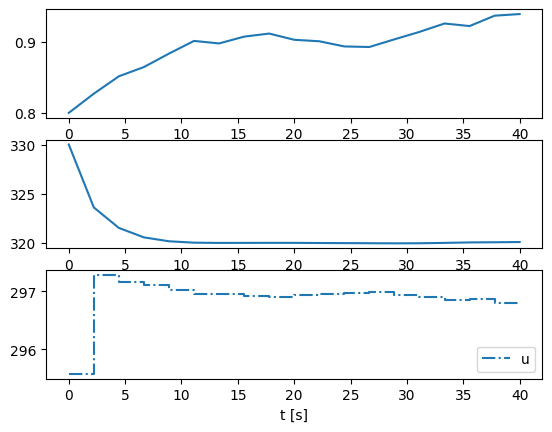

In [149]:
# Create a time grid for plotting
tgrid = np.linspace(0, 4*T, ts+1)

# Extract the optimal values
x_opt = x_log
u_opt =  np.array(U_log[:ts])
u_opt_stairs = np.append(u_opt, np.nan)
# Create a new figure
plt.figure()


# Plot x1 and x2
plt.subplot(3, 1, 1)
plt.plot(tgrid, x_opt[0, :], label='x1')
plt.subplot(3, 1, 2)
plt.plot(tgrid, x_opt[1, :], label='x2')

# Plot u with stairs and add a NaN at the end

plt.subplot(3, 1, 3)
plt.step(tgrid, u_opt_stairs, '-.', where='post', label='u')

# Add labels and legend
plt.xlabel('t [s]')
plt.legend()

# Show the plot
plt.show()


Oracle Class

In [447]:
class oracle():
    '''
    Oracle Class - Class to solve the optimal control problem with perfect 
    knowledge of the environment.

    Inputs: Env

    Outputs: Optimal control and state trajectories
    '''

    def __init__(self,env,env_params):  
      self.env = env(env_params)
      self.env_params = env_params
      self.T = 10
      self.N = 6
      self.model_info = self.env.model.info()
    def model_gen(self):
      '''
      Generates a model for the given environment.

      Returns:
      f: A casadi function that can be used to solve the differential equations defined by the model.
      '''
      self.u  = MX.sym('u',self.env.Nu)
      
      self.x = MX.sym('x',self.env.Nx)
      dxdt = self.env.model(self.x,self.u)
      dxdt = vertcat(*dxdt)
      f = Function('f',[self.x,self.u],[dxdt],['x','u'],['dxdt'])
      return f
    
    def integrator_gen(self):
      '''
      Generates an integrator object for the given model.

      Returns:
      F: A casadi function that can be used to integrate the model over a given time horizon.
      '''
      f = self.model_gen()
      intg_options = {'tf': T/N, 'simplify': True, 'number_of_finite_elements': 4}
      dae = {'x': self.x, 'p': self.u, 'ode': f(self.x, self.u)}
      intg = integrator('intg', 'rk', dae, intg_options)
      res = intg(x0=self.x, p=self.u)
      x_next = res['xf']
      F = Function('F',[self.x,self.u],[x_next],['x','u'],['x_next'])
      return F
    def disturbance_index(self):
      
      '''
      Generates the indices of when the disturbance value changes.
      
      Inputs: self

      Returns: index of when the disturbance value changes.
      
      '''
      for key in self.env_params['disturbances']:
        disturbance = self.env_params['disturbances'][key]
        index = []
        for i in range(disturbance.shape[0]-1):
          if disturbance[i] != disturbance[i+1]:
            index.append(i+1)
        return index
       
    def ocp(self,t_step):
      """
      Solves an optimal control problem (OCP) using the IPOPT solver.

      Returns:
      - M: A function that takes current state x_0 (p) and returns the optimal control input u.

      """
      opti = Opti()
      F = self.integrator_gen()
      x = opti.variable(self.env.Nx, self.N+1)
      # Define the control variable

  
      u = opti.variable(self.env.Nu, self.N)
           
      p = opti.parameter(self.env.Nx, 1)
     
      
      setpoint = opti.parameter(1, self.N+1)
      cost = sum1(sum2((x[0,:] - setpoint)**2)) #TO DO: Remember to change this when custom rewards are implemented
      opti.minimize(cost)

      for k in range(self.N):
        opti.subject_to(x[:, k+1] == F(x[:, k], u[:, k]))

      opti.subject_to(u[0,:] >= self.env_params['a_space']['low'])
      opti.subject_to(u[0,:] <= self.env_params['a_space']['high'])
      
      if env_params['disturbances'] is not None:
        for i, k in enumerate(self.env.model.info()['disturbances'], start=0):
          if k in self.env.disturbances.keys():
            print(self.env.disturbances[k][t_step])
            opti.subject_to(u[self.env.Nu-len(self.env.model.info()['disturbances'])+i,:] == self.env.disturbances[k][t_step]) # Add disturbance to control vector
            opti.set_initial(u[self.env.Nu-len(self.env.model.info()['disturbances'])+i,:], self.env.disturbances[k][t_step])
          else:
            opti.subject_to(u[self.env.Nu-len(self.env.model.info()['disturbances'])+i,:] == self.model_info['parameters'][str(k)]) # if there is no disturbance at this timestep, use the default value
            opti.set_initial(u[self.env.Nu-len(self.env.model.info()['disturbances'])+i,:], self.model_info['parameters'][str(k)])
       
      opti.subject_to(x[:, 0] == p )
      # TODO: Add user-defined constraints  

      opti.solver('ipopt')
      setpoint_value = np.array([[0.9]*(self.N+1)])  # TODO: Make agnostic to model & setpoint variation
      
      opti.set_value(setpoint, setpoint_value)
      opti.set_value(p, [0.8,330]) # TODO: Make agnostic to model
      initial_x_values = np.zeros((2, self.N+1))
      initial_x_values[0, :] = 0.8 # TODO: Make agnostic to model
      initial_x_values[1, :] = 330 # TODO: Make agnostic to model
      opti.set_initial(x, initial_x_values)

     
     
      opti.set_initial(u[0,:], 297) # TODO: Make agnostic to model
     

      opts = {
        'ipopt': {
          'print_level': 0,
        },
        'print_time': 0
      }

    
      opti.solver('ipopt', opts)
      M = opti.to_function('M', [p], [u[:,1]], ['p'], ['u'])
      return M
    
    def mpc(self):
      '''
      Solves a model predictive control problem (MPC) using the optimal control problem (OCP) solver.

      Returns:
      - x_opt: Optimal state trajectory
      - u_opt: Optimal control trajectory
      '''
      regen_index = self.disturbance_index()
      print(regen_index)
      M = self.ocp(t_step=0)
      F = self.integrator_gen()
      self.ts = 100
      u_log = np.zeros((self.env.Nu,self.ts))
      x_log = np.zeros((self.env.Nx,self.ts))
      x = np.array(x0)
      for i in range(self.ts):
          # print(i)
          if i in regen_index:
            M = self.ocp(t_step=i)
            # print('reformulating ocp')
          
          try:
              x_log[:,i] = x
          except:
              x_log[:,i] = x.reshape(-1)
          if self.env_params['noise'] is True:
            noise_percentage = self.env_params['noise_percentage']
            try:
              x += np.random.normal(0,1,(self.env.Nx)) * x * noise_percentage
            except:
              x += np.random.normal(0,1,(self.env.Nx,1)) * x * noise_percentage
          u = M(x).full()
          #print(u)
          u_log[:,i] = u[0]
          x = F(x,u).full() 
      return x_log, u_log


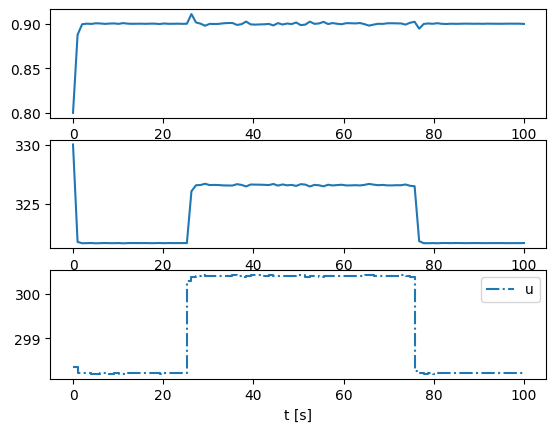

In [449]:
# Create a time grid for plotting
tgrid = np.linspace(0, o.ts, o.ts)

# Create a new figure
plt.figure()


# Plot x1 and x2
plt.subplot(3, 1, 1)
plt.plot(tgrid, x_star[0, :], label='x1')
plt.subplot(3, 1, 2)
plt.plot(tgrid, x_star[1, :], label='x2')

# Plot u with stairs and add a NaN at the end

plt.subplot(3, 1, 3)
plt.step(tgrid, u_star[0,:], '-.', where='post', label='u')

# Add labels and legend
plt.xlabel('t [s]')
plt.legend()

# Show the plot
plt.show()